In [1]:
import pandas as pd
import yaml
import pickle
from utilities.utilities import exposure_function, read_ac_data, gdp_from_cdd_exposure, read_projections, add_historical_gdp_growth, calculate_average_gdp_growth
from utilities.plotting import plot_exposure_map, plot_exposure_contour, plot_gdp_increase_map, plot_gdp_increase_scatter

In [2]:
# Load configuration from config.yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

with open('exposure_function_params.pkl', 'rb') as f:
    params = pickle.load(f)

def exposure_new(gdp, cdd):
    return exposure_function(gdp, params['av_a'], params['av_b'], cdd, params['sat_a'], params['sat_b'], params['sat_c'])

/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities/plotting_classes.py:77: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


    Unnamed: 0 ISO3    DD_mean           GDP  AC  GDP_historical_ref_year  \
62        62.0  GBR  39.249791  44172.434471 NaN             10232.822249   

    gdp_historical_factor  CDD_ssp1_rcp26_2100  CDD_ssp2_rcp45_2100  \
62               0.039237                 63.0                107.0   

    CDD_ssp5_rcp60_2100  GDP_SSP1_2100  GDP_SSP2_2100  GDP_SSP5_2100  \
62                171.0    165073.8502     146846.791    191288.0271   

    exposure_times_cdd  exposure  
62           32.272057  0.822222  
    Unnamed: 0 ISO3  DD_mean           GDP  AC  GDP_historical_ref_year  \
71        71.0  GRL      0.0  55636.205978 NaN              9672.765028   

    gdp_historical_factor  CDD_ssp1_rcp26_2100  CDD_ssp2_rcp45_2100  \
71               0.047116                  0.0                  0.0   

    CDD_ssp5_rcp60_2100  GDP_SSP1_2100  GDP_SSP2_2100  GDP_SSP5_2100  \
71                  0.0            NaN            NaN            NaN   

    exposure_times_cdd  exposure  
71           

/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities/plotting_classes.py:77: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

<Figure size 640x480 with 0 Axes>

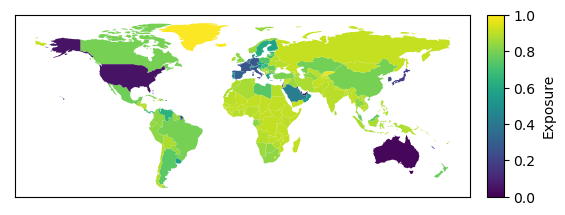

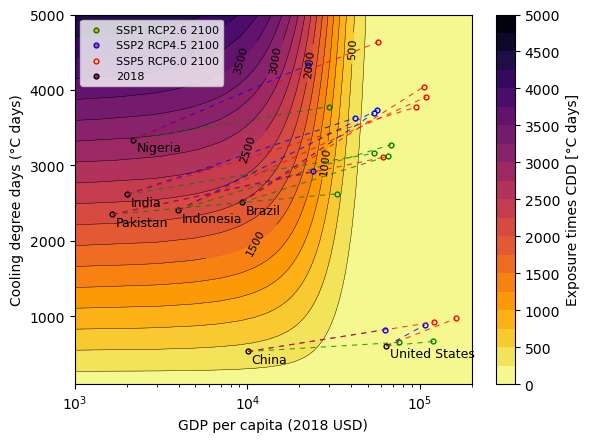

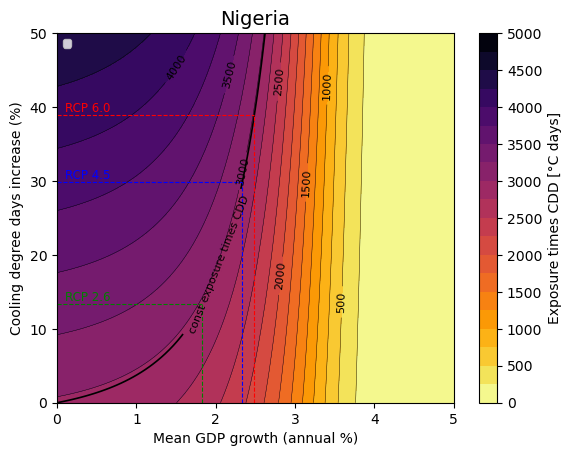

<Figure size 640x480 with 0 Axes>

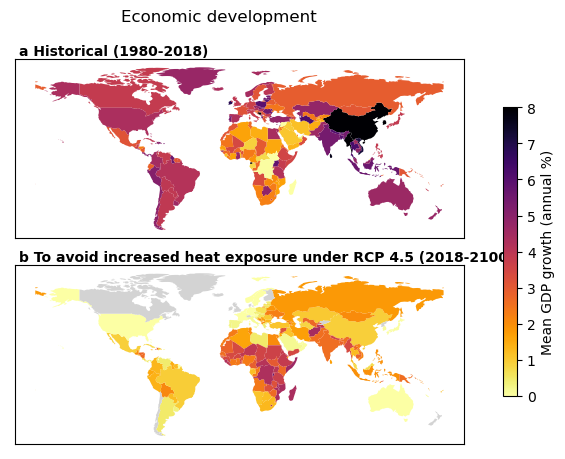

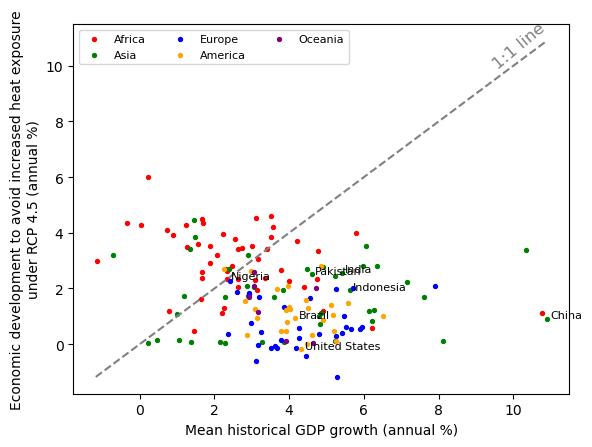

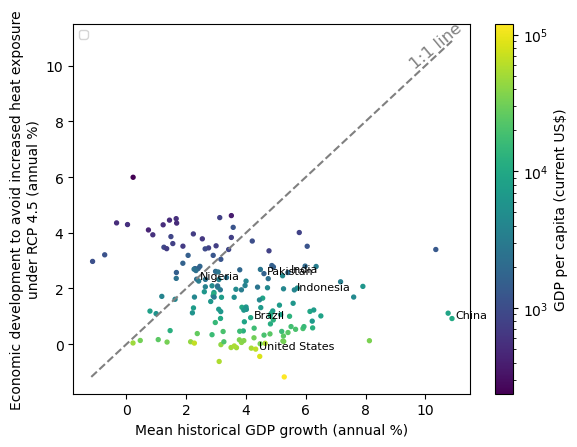

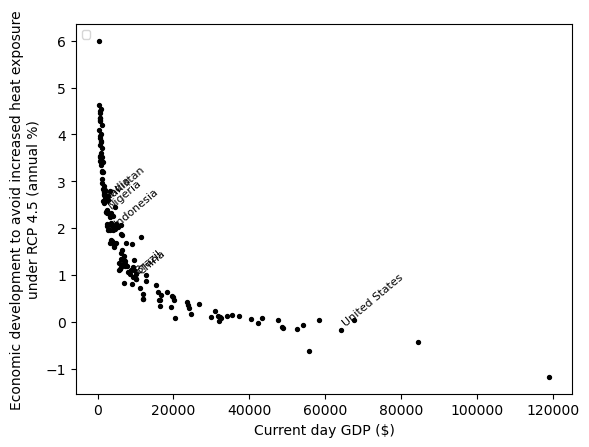

In [3]:
# Read in historical AC, GDP, DD data
ac_data_historical = read_ac_data('data_experiencedT/AC_data.csv')
# Add historical GDP growth
ac_data = add_historical_gdp_growth(ac_data_historical, config)

# Plot exposure map (supporting material)
plot_exposure_map(ac_data_historical, exposure_new)

# Add predictions for DD_mean and GDP for the countries in ac_data
dd_projections = read_projections(config, 'cdd', ac_data_historical)
gdp_projections = read_projections(config, 'gdp', ac_data_historical)

# Merge the two dataframes
merged_projections = pd.merge(dd_projections, gdp_projections, on='ISO3', how='outer')

# Combine historical and projections into one dataframe
ac_data = pd.merge(ac_data, merged_projections, on='ISO3', how='outer')

# Add column for historical exposure times CDD
ac_data['exposure_times_cdd'] = exposure_new(ac_data['GDP'], ac_data['DD_mean'])*ac_data['DD_mean']
ac_data['exposure'] = exposure_new(ac_data['GDP'], ac_data['DD_mean'])

# Plot exposure contour
plot_exposure_contour(config, exposure_new, ac_data, x_y_ranges=[[100, 5000, 100],[1000, 200000, 100]], 
                      name_tag='exposure_contour')

for scenario in config['future_scenarios']:
    # Calculate GDP needed to keep exposure times CDD constant
    gdp_const = gdp_from_cdd_exposure(ac_data['exposure_times_cdd'], ac_data['CDD_{0}_{1}'.format(scenario, config['future_years'][-1])], params)
    ac_data['gdp_const_{}'.format(scenario)] = calculate_average_gdp_growth(gdp_const, ac_data['GDP'], config['future_years'][-1] - config['ref_year'])

# Plot contour for one country with x and y percent increase in CDD and GDP
plot_exposure_contour(config, exposure_new, ac_data, x_y_ranges=[[0, 50, 100],[0, 5, 100]],
                    country='NGA', name_tag='exposure_contour_country_NGA')

for scenario in [config['base_future_scenario']]:
    plot_gdp_increase_map(config, ac_data, scenario, exposure_new)
    plot_gdp_increase_scatter(config, ac_data, scenario, color_scale='continent')
    plot_gdp_increase_scatter(config, ac_data, scenario, color_scale='gdp')
    plot_gdp_increase_scatter(config, ac_data, scenario, color_scale='vs_gdp')
